<a href="https://colab.research.google.com/github/mohamedelziat50/Fruit-Recognition-MIU/blob/main/Fruit_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Processing project for fruit recognition using the Fruits-360 dataset.

### Import The Necessary Libraries

In [6]:
import kagglehub
import os, sys
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow

### Import The [Fruits-360 Dataset](https://www.kaggle.com/datasets/moltean/fruits) From Kaggle

In [7]:
# Load the dataset directly from kaggle (gives us the root path)
kaggle_dataset_path = kagglehub.dataset_download("moltean/fruits")

# Get the correct dataset path, by going inside the folders
dataset_path = os.path.join(kaggle_dataset_path, "fruits-360_100x100", "fruits-360")
print(f"Updated dataset path: {dataset_path}")

# Preview the contents of the path to double-check
print("\nFiles in the Dataset directory:", os.listdir(dataset_path))

Using Colab cache for faster access to the 'fruits' dataset.
Updated dataset path: /kaggle/input/fruits/fruits-360_100x100/fruits-360

Files in the Dataset directory: ['LICENSE', 'Training', 'README.md', 'Test']


### Store the Training & Testing paths independently

In [8]:
# Join the correct paths (checkout out the dataset's folder names on kaggle)
training_path = os.path.join(dataset_path, "Training")
testing_path = os.path.join(dataset_path, "Test")

# Display the Paths
print(f"Training Path: {training_path}")
print(f"Testing Path: {testing_path}\n")

# Check if directories exist
print("Training directory exists:", os.path.exists(training_path))
print("Testing directory exists:", os.path.exists(testing_path))

Training Path: /kaggle/input/fruits/fruits-360_100x100/fruits-360/Training
Testing Path: /kaggle/input/fruits/fruits-360_100x100/fruits-360/Test

Training directory exists: True
Testing directory exists: True


### Display sample images from the training dataset.
#### First, we need to pick a fruit category (subdirectory or 'label' in correct terms) and then an image from that category.
#### Defined a function that allows the user to input how many categories & images they'd like to see!

In [9]:
def display_categories(fruit_categories, no_of_categories, no_of_images):
  if no_of_categories <= 0 or no_of_categories > len(fruit_categories):
    sys.exit("Invalid Number of Categories requested. Exiting.")
  if no_of_images <= 0 or no_of_images > 100:
    sys.exit("Invalid Number of Images requested per category. Must be a positive number and atmost 100. Exiting.")

  # Loop over each category, and display the specified number of images
  for category in fruit_categories[:no_of_categories]:
    category_path = os.path.join(training_path, category)

    # Get a list of images in that category
    category_images = os.listdir(category_path)

    # Handle the case there's an error of loading the images in the first category
    if not category_images:
        sys.exit(f"No images found in the category: {category}. Exiting.")

    # Display the category & total number of images
    print(f"========= Category: {category}, Total Number of Images: {len(category_images)} =========")

    # Loop over the requested number of images
    for image in category_images[:no_of_images]:
      image_path = os.path.join(category_path, image)
      print(f"Image path: {image_path}")

      # Read the image using OpenCV
      image = cv.imread(image_path)

      # Handle the case there's an error of loading the image
      if image is None:
          sys.exit("Error: Could not load the image. Exiting.")

      # Display the image
      cv2_imshow(image)

Number of Fruit Categories (Labels): 226

========= Category: Melon Piel de Sapo 1, Total Number of Images: 738 =========
Image path: /kaggle/input/fruits/fruits-360_100x100/fruits-360/Training/Melon Piel de Sapo 1/r2_162_100.jpg


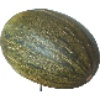

Image path: /kaggle/input/fruits/fruits-360_100x100/fruits-360/Training/Melon Piel de Sapo 1/r_305_100.jpg


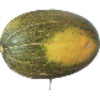

========= Category: Dates 1, Total Number of Images: 490 =========
Image path: /kaggle/input/fruits/fruits-360_100x100/fruits-360/Training/Dates 1/r_305_100.jpg


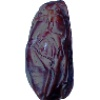

Image path: /kaggle/input/fruits/fruits-360_100x100/fruits-360/Training/Dates 1/r_239_100.jpg


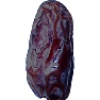

========= Category: Avocado Black 2, Total Number of Images: 738 =========
Image path: /kaggle/input/fruits/fruits-360_100x100/fruits-360/Training/Avocado Black 2/r2_162_100.jpg


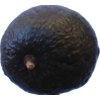

Image path: /kaggle/input/fruits/fruits-360_100x100/fruits-360/Training/Avocado Black 2/r2_297_100.jpg


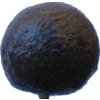

In [10]:
# Get a list of all fruit categories (subdirectories) in the training path
fruit_categories = os.listdir(training_path)

# Handle the case there's an error of loading the categories
if not fruit_categories:
    sys.exit("No fruit categories found in the training path. Exiting.")

# Display how many labels/categories we have
print("Number of Fruit Categories (Labels):", len(fruit_categories), end="\n\n")

display_categories(fruit_categories, 3, 2)